In [135]:
# import packages
import pandas as pd
import numpy as np
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", rc={"figure.figsize":(12, 5)})
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


In [136]:
# load dataset
url = 'monthly_sales_data.csv'
sales_data = pd.read_csv(url)

In [137]:
# show dataset
sales_data.head()

,Category,Month,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
0,Sports,2002-01-01,108592,2002,1,Xbox,1,0
1,RPG,2002-02-01,129387,2002,4,Nintendo,0,0
2,Sports,2002-03-01,114777,2002,4,PC,0,0
3,Sports,2002-04-01,71738,2002,0,Nintendo,0,0
4,Simulation,2002-05-01,142512,2002,2,PlayStation,0,0


In [138]:
# Convert Month column to datetime object
sales_data['Month'] = pd.to_datetime(sales_data['Month'])

In [173]:
sales_ts = sales_data.set_index('Month')[['Monthly Sales']]
sales_ts.tail()

,Monthly Sales
Month,
2023-08-01,132693
2023-09-01,143373
2023-10-01,126410
2023-11-01,91200
2023-12-01,159721


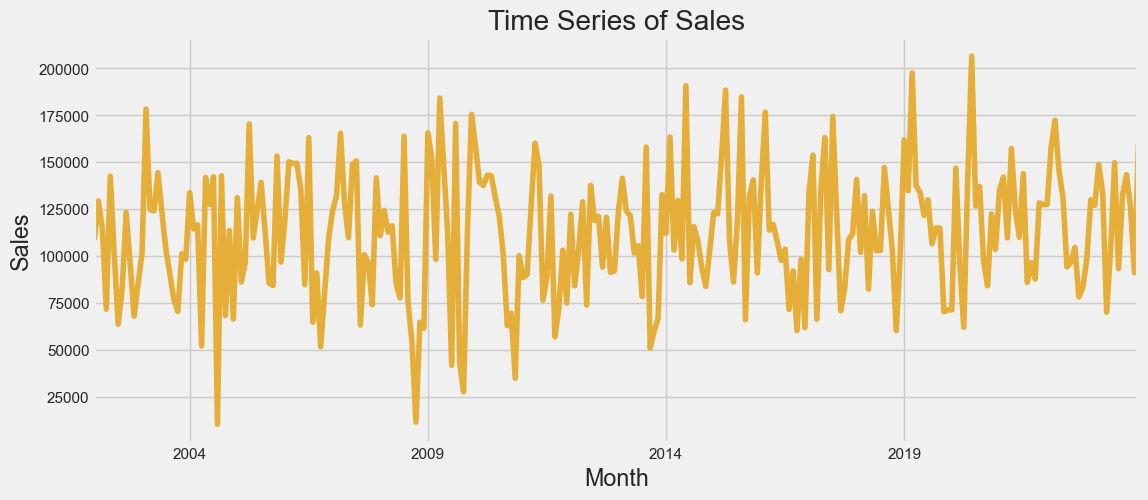

In [140]:
# plot the time series
color_pal = sns.color_palette()
sales_ts['Monthly Sales'].plot(style='-', figsize=(12,5), ms=2, title='Time Series of Sales', 
                               color= color_pal[2], ylabel='Sales');

### Decompose Time Series

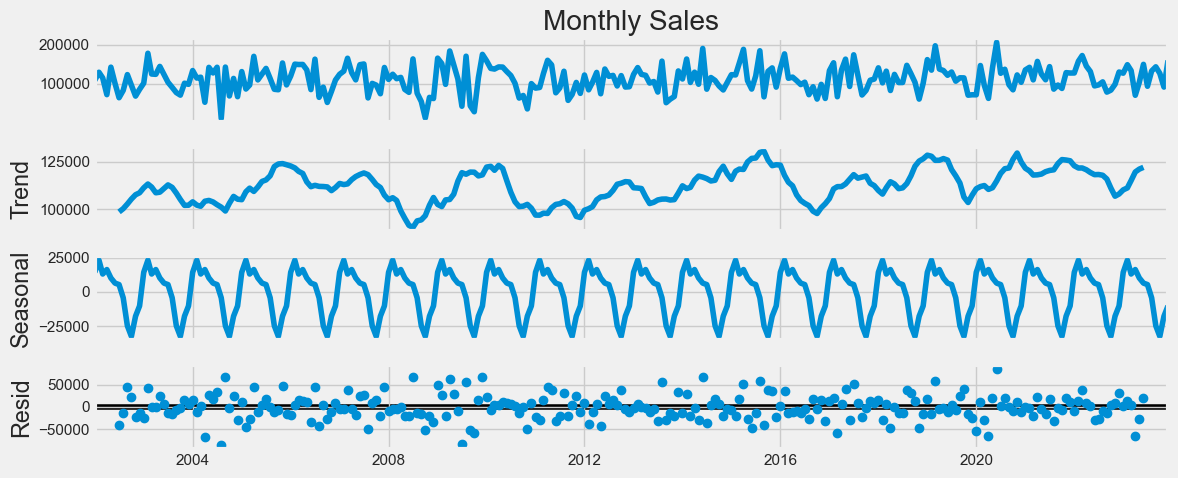

In [174]:
# decompose time series into components
sales_decompose = seasonal_decompose(sales_ts['Monthly Sales'], model='additive')

sales_decompose.plot()
plt.show()

In [176]:
# verify it's multiplicative
sales_decompose.observed.iloc[45] == sales_decompose.trend.iloc[45] + sales_decompose.seasonal.iloc[45]\
                                            + sales_decompose.resid.iloc[45]

True

### Check for Stationary

In [143]:
# Check for stationarity by rolling windows
def check_stationary(df, col):
    df['rollmean'] = df[col].rolling(window=12).mean()
    df['rollstd'] = df[col].rolling(window=12).std()
    
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df, x=df.index, y=df[col])
    sns.lineplot(data=df, x=df.index, y=df['rollmean'])
    sns.lineplot(data=df, x=df.index, y=df['rollstd']);

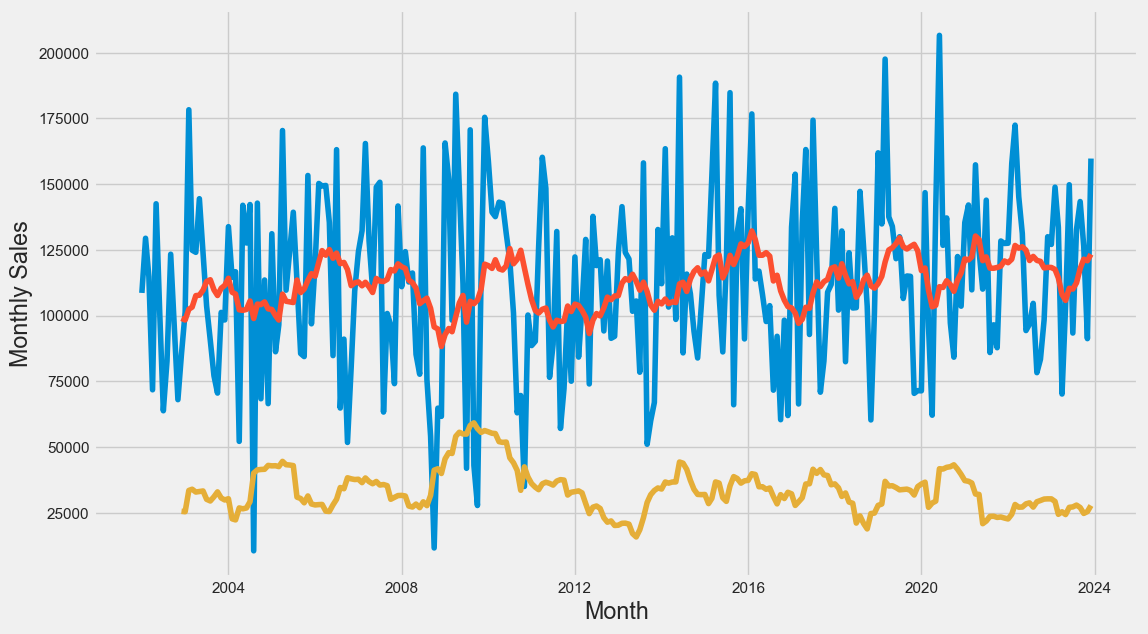

In [144]:
check_stationary(sales_ts, 'Monthly Sales')

### Tests for stationarity.
> **KPSS**:
>>*$H_{0}$*: *The data is stationary*.<br>
>>*$H_{1}$*: *The data is not stationary*.<br>
>
> **Adfuller**:<br>
>>*$H_{0}$*: *The data possesses a unit root is not stationary*.<br>
>>*$H_{1}$*: *The data is stationary*.


In [145]:
# import test libraries
from statsmodels.tsa.stattools import kpss, adfuller

In [146]:
# function to test
def is_stationary(x):
    threshold = 0.05
    
    # for KPSS test
    stats, p, _, critical_val = kpss(x, 'ct')
    print(f'=======================KPSS=========================')
    print(f'Test Statistics = {stats}')
    print(f'p-value: {p}')
    print(f'Critical Values: {critical_val}')
    
    if p < threshold:
        kpss_log = f'For KPSS, Time Series is not stationary'
    else:
        kpss_log = f'For KPSS, Time Series is stationary'
    print(kpss_log)
        
    # for Adfuller test
    result = adfuller(x)
    print(f'\n====================Adfuller========================')
    print(f'Test Statistics = {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')
    
    if result[1] > threshold:
        adfull_log = f'For Adfuller, Time Series is not stationary'
    else:
        adfull_log = f'For Adfuller, Time Series is stationary'
    print(adfull_log)
          
    statement = 'Time Series is stationary'
    return (statement in kpss_log and statement in adfull_log)
        

In [147]:
is_stationary(sales_ts['Monthly Sales'])

=======================KPSS=========================
Test Statistics = 0.02700949774080778
p-value: 0.1
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
For KPSS, Time Series is stationary

====================Adfuller========================
Test Statistics = -4.471046070251255
p-value: 0.00022173509005268826
Critical Values: {'1%': -3.4565688966099373, '5%': -2.8730786194395455, '10%': -2.5729189953388762}
For Adfuller, Time Series is stationary


True

### Train/Test Split

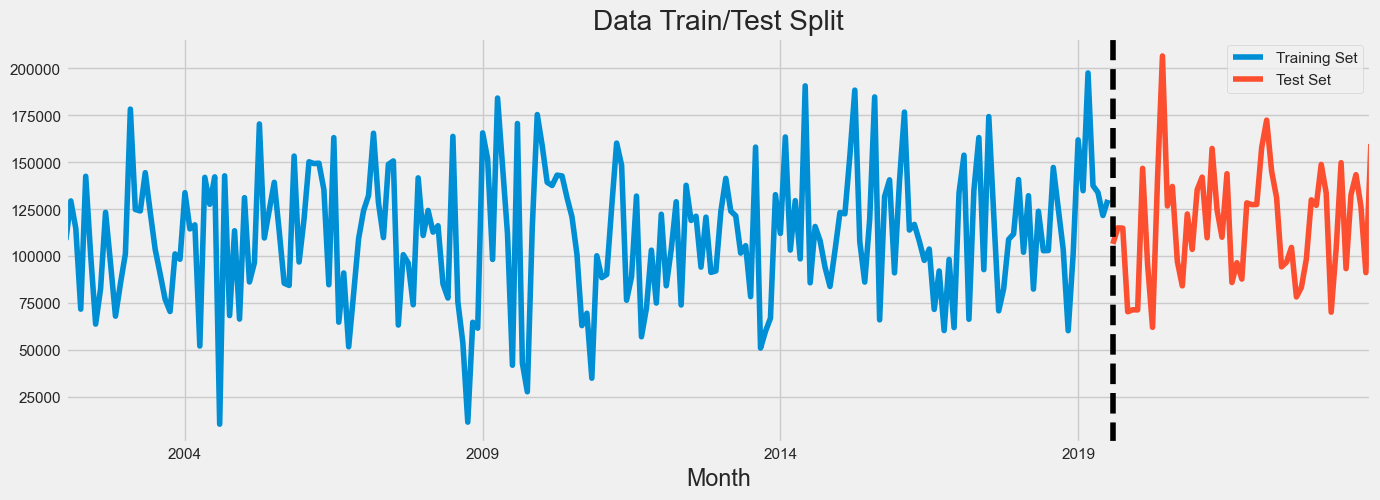

In [148]:
# split time series into train and test data
idx = round(len(sales_ts) * .8)
split_date = sales_ts.iloc[[idx]].index[0].strftime('%Y-%m-%d')
#train = sales_ts.loc[sales_ts.index <= split_date]
#test = sales_ts.loc[sales_ts.index > split_date]
train = sales_ts[['Monthly Sales']][: idx]
test = sales_ts[['Monthly Sales']][idx:]

# visualise the train/test split
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Implementing Holt Winters (ExponentialSmoothing)

In [149]:
# import libraries
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [150]:
# Fit simple model and get forecasts
model_simple = SimpleExpSmoothing(train['Monthly Sales'])
model_fit = model_simple.fit()
prediction = model_fit.predict(start=test.index[0], end=test.index[-1])

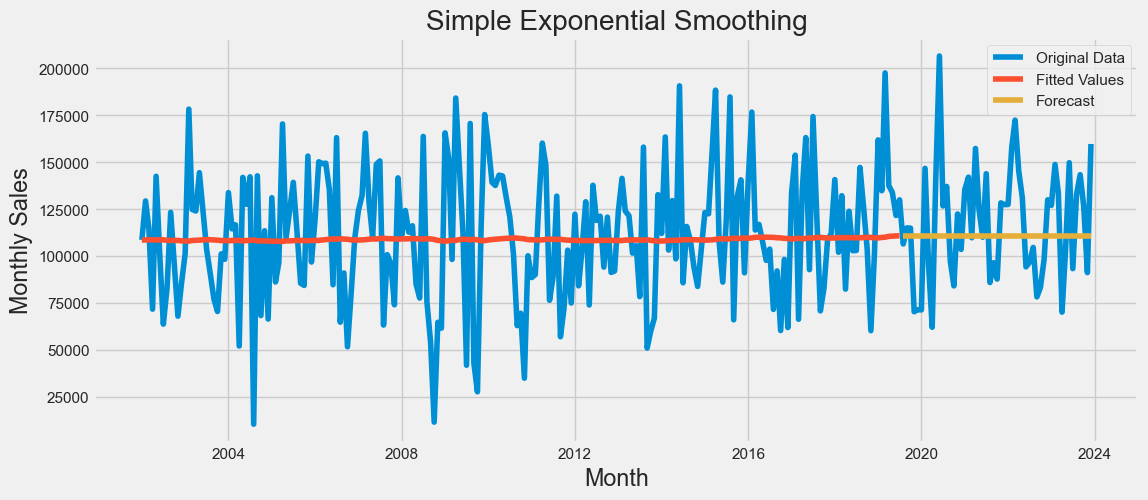

In [151]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_fit.fittedvalues, label='Fitted Values')
plt.plot(prediction, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

In [152]:
# Fit simple model and get forecasts
model = Holt(train['Monthly Sales'], damped_trend=True)
model_holt = model.fit()
predict_holt = model_holt.predict(start=test.index[0], end=test.index[-1])

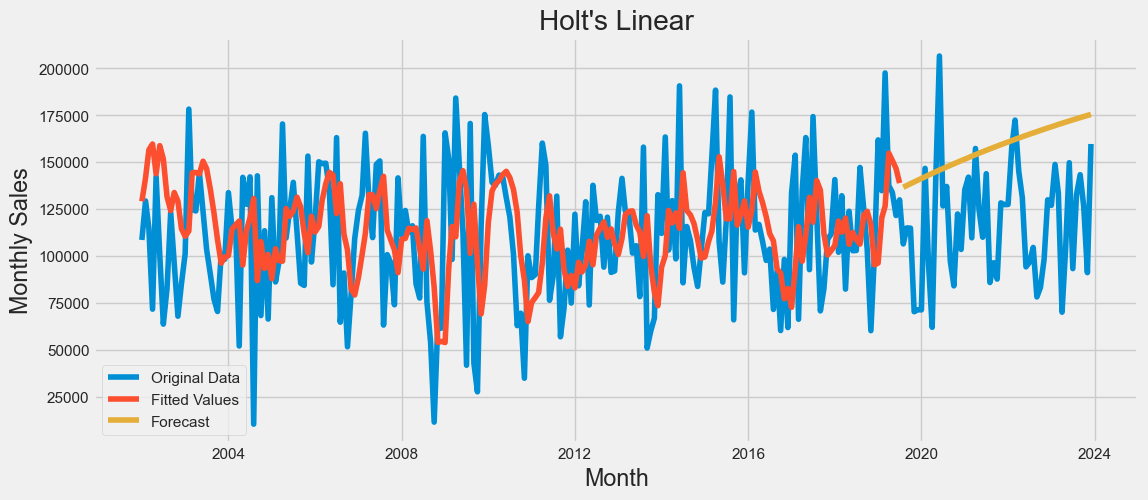

In [153]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_holt.fittedvalues, label='Fitted Values')
plt.plot(predict_holt, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title("Holt's Linear")
plt.legend()
plt.show()

In [177]:
# Fit simple model and get forecasts
model = ExponentialSmoothing(train['Monthly Sales'], trend='add', seasonal='add', seasonal_periods=12)
model_holt_winters = model.fit()
predict_holt_winters = model_holt_winters.predict(start=test.index[0], end=test.index[-1])

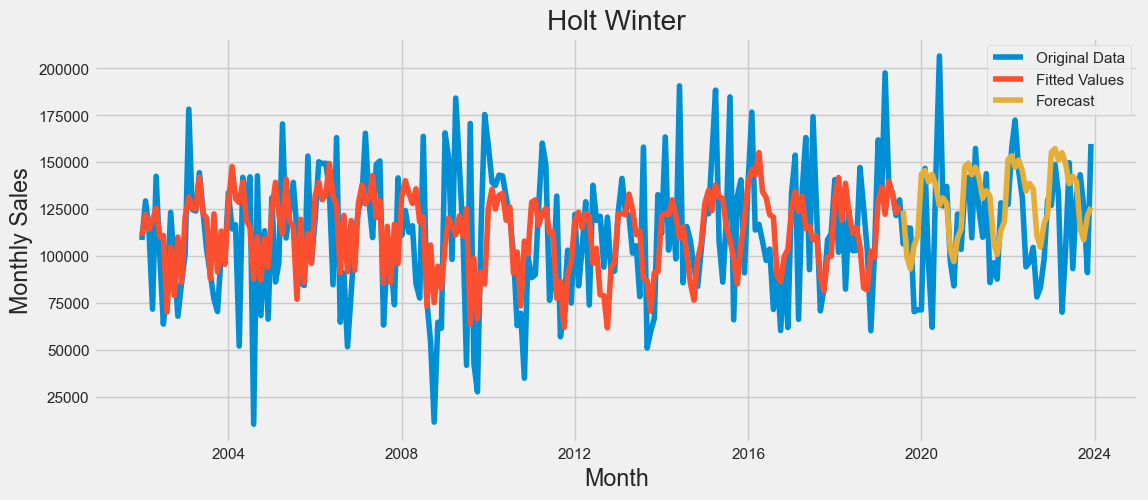

In [178]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_holt_winters.fittedvalues, label='Fitted Values')
plt.plot(predict_holt_winters, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('Holt Winter') 
plt.legend()
plt.show()

In [156]:
# create the timestamp to forecasting
futuredate = pd.DataFrame(pd.date_range(start='2024-01-01', end='2024-04-01', freq='MS'), columns=['Dates'])
futuredate.set_index('Dates', inplace=True)
futuredate

""
Dates
2024-01-01
2024-02-01
2024-03-01
2024-04-01


In [179]:
# forecast four months ahead for Exponential Smoothing
model_holt_winters.predict(start=futuredate.index[0], end=futuredate.index[-1])

2024-01-01    159122.458715
2024-02-01    161135.279139
2024-03-01    154997.840755
2024-04-01    158967.131288
Freq: MS, dtype: float64

### ARIMA Model

In [158]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

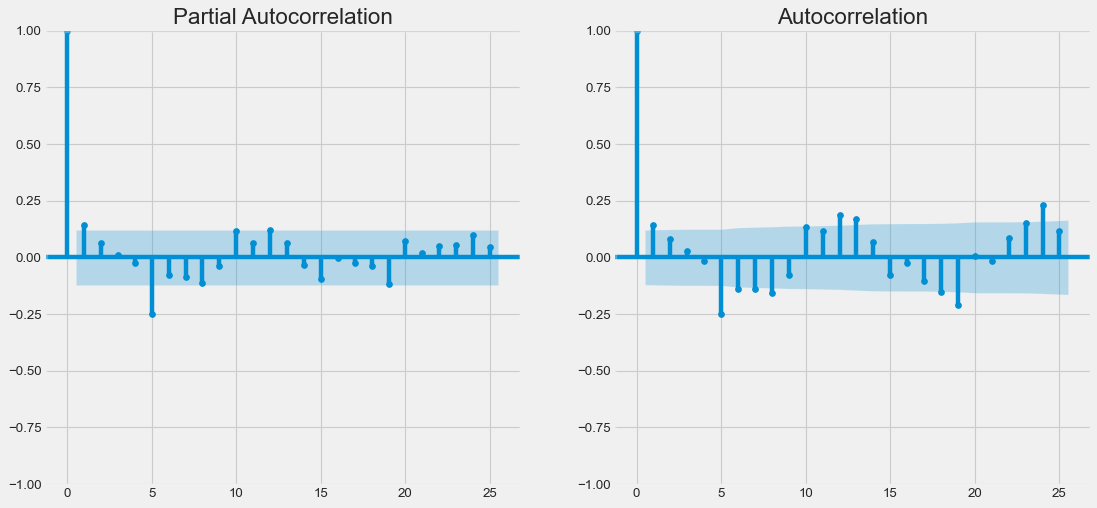

In [159]:
# plot the the correlation graphs
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7), dpi=80)
plot_pacf(sales_ts['Monthly Sales'], ax=ax1);
plot_acf(sales_ts['Monthly Sales'], ax=ax2);

# decorate
ax1.spines['top'].set_alpha(.3);ax2.spines['top'].set_alpha(.3)
ax1.spines['bottom'].set_alpha(.3);ax2.spines['bottom'].set_alpha(.3)
ax1.spines['right'].set_alpha(.3);ax2.spines['right'].set_alpha(.3)
ax1.spines['left'].set_alpha(.3);ax2.spines['left'].set_alpha(.3)

# font size of tick labels
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

### Build Baseline ARIMA Model
- The most significant lag for the Pacf plot is 5. while the Acf is sinusoidal. Hence, the ARIMA model is ARIMA(5, 0, 5).

In [160]:
from statsmodels.tsa.arima.model import ARIMA

# fit model to data and predict 
model_arima = ARIMA(train['Monthly Sales'], order=(5, 0, 5)).fit()
predict_arima = model_arima.predict(start=test.index[0], end=test.index[-1], freq=['MS'])

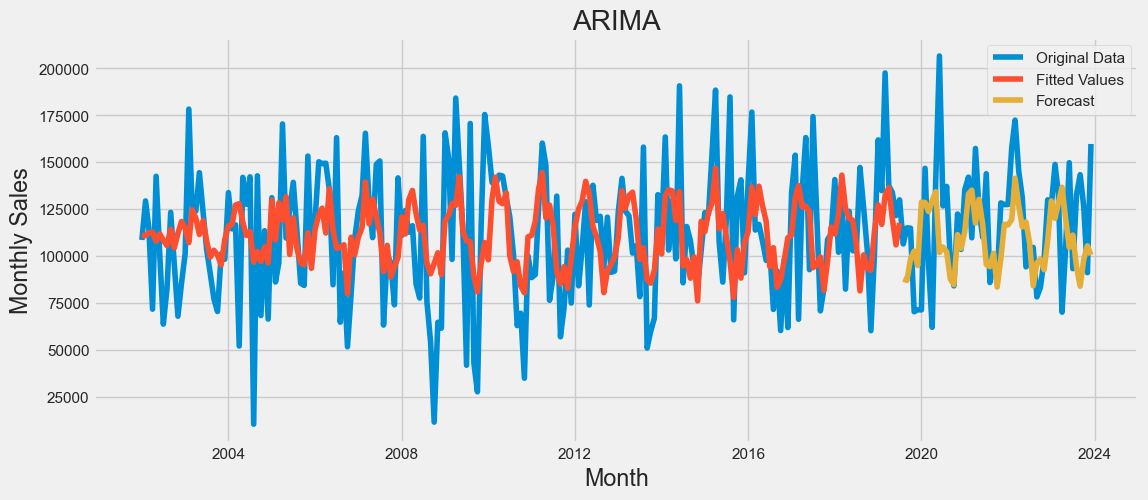

In [161]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_arima.fittedvalues, label='Fitted Values')
plt.plot(predict_arima, label='Forecast')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('ARIMA') 
plt.legend()
plt.show()

In [162]:
# forecast four months ahead with Arima
model_arima.predict(start=futuredate.index[0], end=futuredate.index[-1])

2024-01-01    123233.190012
2024-02-01    133684.673002
2024-03-01    124158.939084
2024-04-01    126387.908453
Freq: MS, Name: predicted_mean, dtype: float64

### Searching for the optimal parameters for Arima(p, d, q).

In [233]:
from sklearn.metrics import mean_squared_error
from mango import scheduler, Tuner

def arima_objective_function(args_list):
    global data_values

    params_evaluated = []
    results = []

    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            trend = params['trend']

            model = ARIMA(data_values, order=(p,d,q), trend = trend)
            predictions = model.fit()

            mse = mean_squared_error(data_values, predictions.fittedvalues)
            params_evaluated.append(params)
            results.append(mse)
        except:
            # params_evaluated.append(params)
            # results.append(1e5)
            continue

        #print(params_evaluated, mse)
    return params_evaluated, results

#### Define Parameter Space

In [239]:
# parameter space
param_space = dict(p = range(0, 30), d = [0],
                   q = range(0, 30),
                   trend = ['n', 'c', 't', 'ct']
                  )

In [240]:
conf_Dict = dict()
conf_Dict['num_iteration'] = 100

In [241]:
data_values = list(train['Monthly Sales'])

In [242]:
tuner = Tuner(param_space, arima_objective_function, conf_Dict)

In [243]:
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

Best score: 741183025.7892345: 100%|███████████████████████████████████████████████| 100/100 [1:51:55<00:00, 67.15s/it]


best parameters: {'d': 0, 'p': 27, 'q': 29, 'trend': 'ct'}
best loss: 741183025.7892345


In [244]:
# fit final model to data and predict 
final_arima_model = ARIMA(train['Monthly Sales'], order=(27, 0, 29), trend='ct').fit()
predict_final_arima = final_arima_model.predict(start=test.index[0], end=test.index[-1], freq=['MS'])

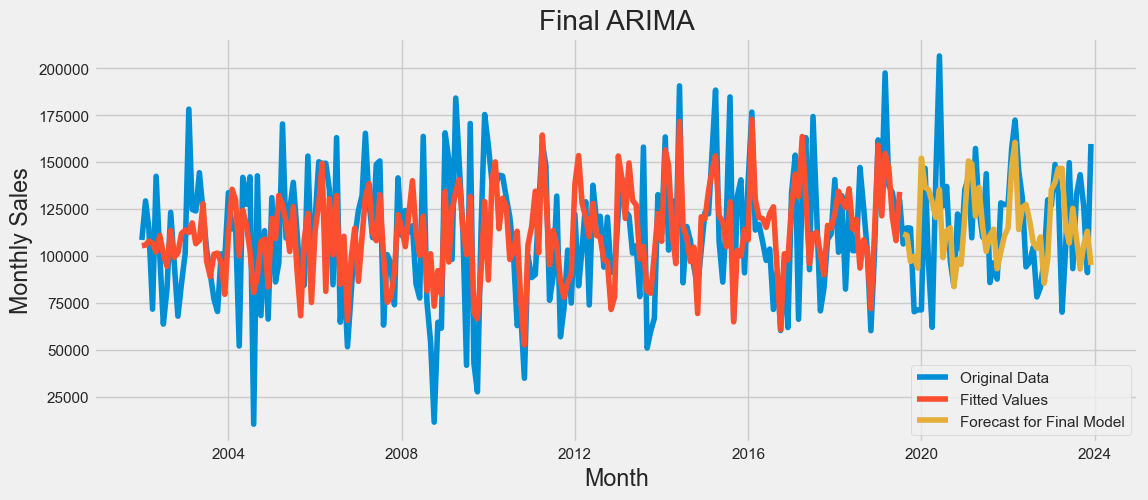

In [245]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(final_arima_model.fittedvalues, label='Fitted Values')
plt.plot(predict_final_arima, label='Forecast for Final Model')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('Final ARIMA') 
plt.legend()
plt.show()

In [246]:
# forecast four months ahead with final Arima
model_arima.predict(start=futuredate.index[0], end=futuredate.index[-1])

2024-01-01    123233.190012
2024-02-01    133684.673002
2024-03-01    124158.939084
2024-04-01    126387.908453
Freq: MS, Name: predicted_mean, dtype: float64

### SARIMA

In [261]:
# import library
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

In [262]:
# setting the parameter space for SARIMAX
p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]
print(f'Instances of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))

Instances of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)


In [269]:
# search for optimal combination

params_grid = dict()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train[['Monthly Sales']], order=param,
                           seasonal_order=param_seasonal,
                           enforce_stationarity=False,
                            enforce_invertibility=False,)
            results = model.fit()
            params_grid[results.aic] = f'ARIMA {param}x{param_seasonal}'
            keys = sorted(params_grid.keys())
            # print(f'ARIMA {param}x{param_seasonal}12 -- AIC: {results.aic}')
        except:
            continue

In [275]:
for param in [f'{params_grid[key]} : {key}' for key in keys[:5]]:
    print(param)

ARIMA (1, 1, 1)x(0, 1, 1, 12) : 4410.700905136976
ARIMA (1, 1, 1)x(1, 1, 1, 12) : 4411.887591987436
ARIMA (0, 1, 1)x(0, 1, 1, 12) : 4412.557144391163
ARIMA (0, 1, 1)x(1, 1, 1, 12) : 4413.6360887224455
ARIMA (0, 0, 1)x(1, 1, 1, 12) : 4427.694157365205


#### Fitting the Sarima Model

In [276]:
# fit model to data
model_sarima = SARIMAX(train[['Monthly Sales']], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), 
                       enforce_stationarity=False, 
                        enforce_invertibility=False)
model_results = model_sarima.fit()

In [277]:
print(model_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2115      0.142     -1.487      0.137      -0.490       0.067
ma.L1         -0.7373      0.100     -7.374      0.000      -0.933      -0.541
ma.S.L12      -0.8101      0.078    -10.351      0.000      -0.963      -0.657
sigma2      2.188e+09   3.47e-12    6.3e+20      0.000    2.19e+09    2.19e+09


#### Run Model Diagnostics

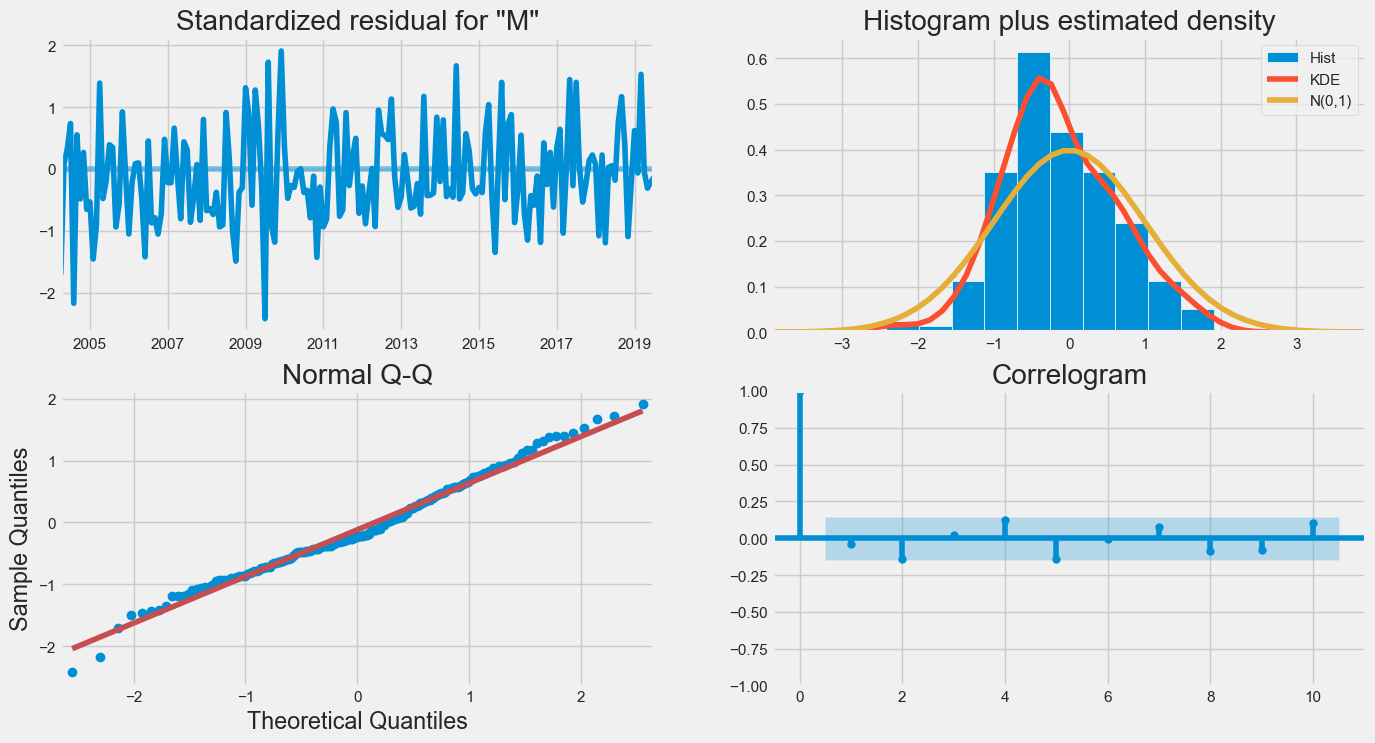

In [279]:
model_results.plot_diagnostics(figsize=(15, 8))
plt.show()

In [281]:
# fit final model to data and predict 
predict_sarima = model_results.predict(start=test.index[0], end=test.index[-1], freq=['MS'])

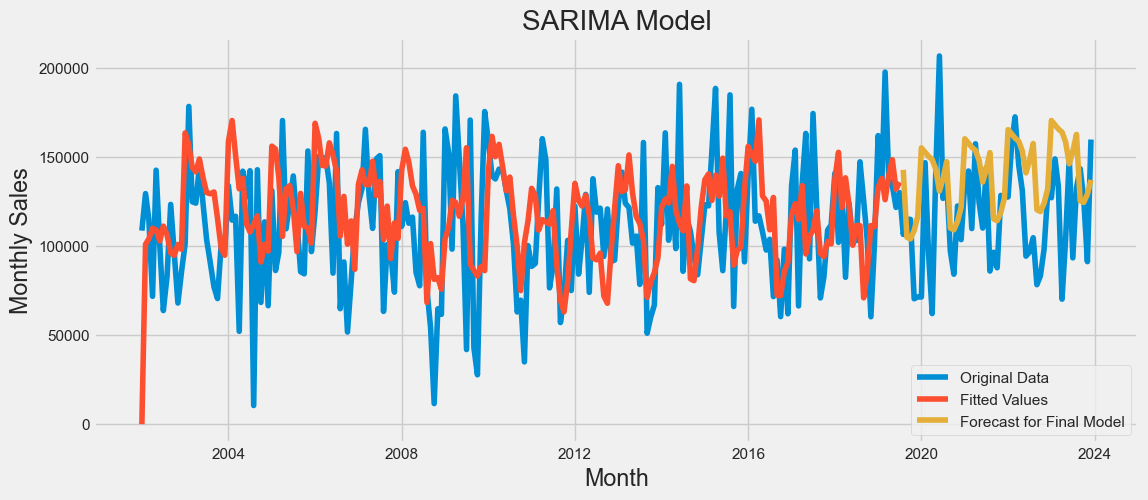

In [282]:
plt.plot(sales_ts['Monthly Sales'], label='Original Data')
plt.plot(model_results.fittedvalues, label='Fitted Values')
plt.plot(predict_sarima, label='Forecast for Final Model')
plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('SARIMA Model') 
plt.legend()
plt.show()

In [283]:
# forecast four months ahead with final Arima
model_results.predict(start=futuredate.index[0], end=futuredate.index[-1])

2024-01-01    175497.300444
2024-02-01    173036.916491
2024-03-01    170748.503081
2024-04-01    168987.069124
Freq: MS, Name: predicted_mean, dtype: float64